In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

In [3]:
train_df = pd.read_csv("../input/global-wheat-detection/train.csv")
train_df.drop(['width','source','height'],axis=1,inplace=True)
train_df.head()

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"


In [4]:
image_ids = train_df['image_id'].unique()

images = image_ids[:10]

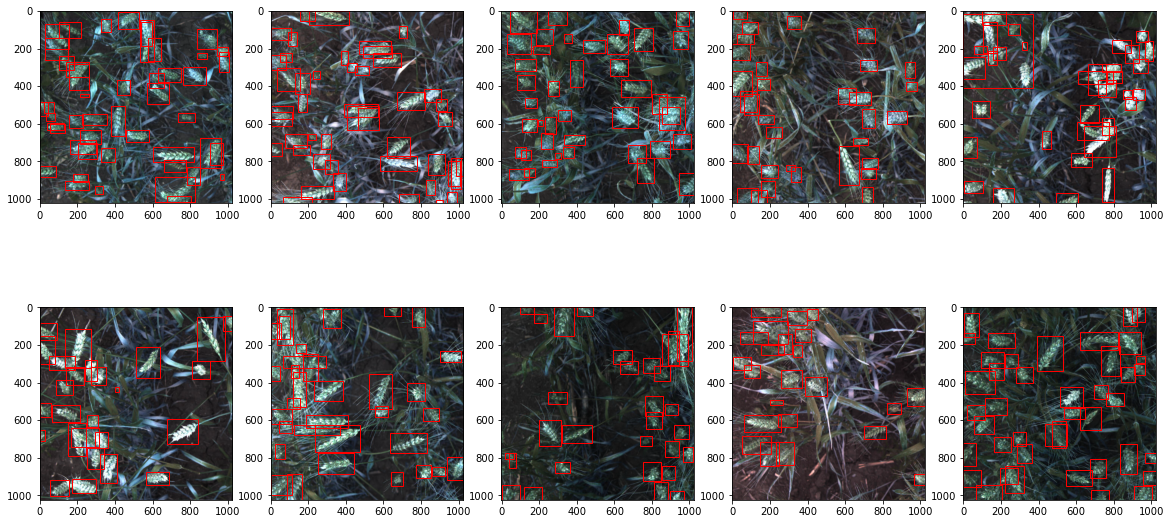

In [5]:
fig,a =  plt.subplots(2,5,figsize=(20,10))
row = 0
col = 0

for n,i in enumerate(images):
    img = cv2.imread("../input/global-wheat-detection/train/"+i+".jpg")
    a[row][col].imshow(img)
    
    for j in train_df[train_df['image_id'] == i]['bbox']:
        dim = j[1:-1].split()
        dim = [int(float(x[:-1])) for x in dim]
        x,y,width,height = dim[0],dim[1],dim[2],dim[3]
        
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
        a[row][col].add_patch(rect)
        
    col+=1    
    if n==4:
        col = 0
        row = 1
    

In [6]:
train_df['x'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[0])))
train_df['y'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[1])))
train_df['width'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[2])))
train_df['height'] = train_df['bbox'].apply(lambda x: int(float(x[1:-1].split(',')[3])))

In [7]:
train_df.drop('bbox',axis=1,inplace=True)

In [8]:
train_df

,image_id,x,y,width,height
0,b6ab77fd7,834,222,56,36
1,b6ab77fd7,226,548,130,58
2,b6ab77fd7,377,504,74,160
3,b6ab77fd7,834,95,109,107
4,b6ab77fd7,26,144,124,117
...,...,...,...,...,...
147788,5e0747034,64,619,84,95
147789,5e0747034,292,549,107,82
147790,5e0747034,134,228,141,71
147791,5e0747034,430,13,184,79


In [9]:
transform =  A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, transforms):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread("../input/global-wheat-detection/train/"+image_id+".jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)       
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['iscrowd'] = iscrowd
        target['area'] = area
        target['image_id'] = torch.tensor([index])

        sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        sample = self.transforms(**sample)
        image = sample['image']

        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [11]:
train_dataset = WheatDataset(train_df, transform)

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [14]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [17]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [18]:
loss_hist = Averager()

for epoch in range(30):
    loss_hist.reset()
    
    for n,(images, targets, image_ids) in enumerate(train_data_loader):
        n+=1
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

            
    print(f"Epoch : "+str(epoch)+" loss: " +str(loss_hist.value))   

Epoch : 0 loss: 0.7136363867334845
Epoch : 1 loss: 0.625690527719344
Epoch : 2 loss: 0.5973690312479345
Epoch : 3 loss: 0.5788107320171962
Epoch : 4 loss: 0.5628234020200386
Epoch : 5 loss: 0.5507227340580728
Epoch : 6 loss: 0.5406013661510006
Epoch : 7 loss: 0.53149149182001
Epoch : 8 loss: 0.5221458171357476
Epoch : 9 loss: 0.5138724057877798
Epoch : 10 loss: 0.5060006690816292
Epoch : 11 loss: 0.4968255213086639
Epoch : 12 loss: 0.4906430610265777
Epoch : 13 loss: 0.48401134266955026
Epoch : 14 loss: 0.4777835213460063
Epoch : 15 loss: 0.47340149619568017
Epoch : 16 loss: 0.46871259349499833
Epoch : 17 loss: 0.46215138732680777
Epoch : 18 loss: 0.46022723480988453
Epoch : 19 loss: 0.46259643137454987
Epoch : 20 loss: 0.45871461850207
Epoch : 21 loss: 0.4529894225264048
Epoch : 22 loss: 0.4426281519622599
Epoch : 23 loss: 0.43658690754836205
Epoch : 24 loss: 0.4325619377725497
Epoch : 25 loss: 0.4283715194506103
Epoch : 26 loss: 0.4223885077506445
Epoch : 27 loss: 0.4166690458265526


In [19]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pt')